<a href="https://colab.research.google.com/github/anshkumar/elf/blob/master/NSMOCS_ANN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "./drive/My Drive/data.zip" .

In [3]:
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/
   creating: data/VIC/
  inflating: data/VIC/PRICE_AND_DEMAND_201501_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201711_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201710_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201612_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201706_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201707_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201604_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201605_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201510_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201511_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201701_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201609_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201608_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201603_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201602_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201507_VIC1.csv  
  inflating: data/VIC/PRI

In [0]:
class sw(object):

    def __init__(self):

        self.__Positions = []
        self.__Gbest = []

    def _set_Gbest(self, Gbest):
        self.__Gbest = Gbest

    def _points(self, agents):
        self.__Positions.append([list(i) for i in agents])

    def get_agents(self):
        """Returns a history of all agents of the algorithm (return type:
        list)"""

        return self.__Positions

    def get_Gbest(self):
        """Return the best position of algorithm (return type: list)"""

        return list(self.__Gbest)


In [0]:
# -*- coding: utf-8 -*-

"""
@author: vedanshu
"""

import numpy as np
from math import gamma, pi, sin, sqrt, exp, ceil, floor
from random import normalvariate, randint, random, choice, uniform, shuffle

class Activation(object):
    @staticmethod
    def sigmoid(z):
        return 1.0/(1.0 + np.exp(-z))
    
    @staticmethod
    def sigmoid_prime(z):
        return Activation.sigmoid(z)*(1 - Activation.sigmoid(z))

    @staticmethod        
    def tanh(z):
        return 2*Activation.sigmoid(2*z) - 1
        
    @staticmethod
    def relu(z):
        return z * (z > 0)

class Swarm(sw):
    def __init__(self, sizes, activate):
        self.sizes = sizes
        self.activate = activate
        self.dim = sum(x*(y+1) for x,y in zip(self.sizes[1:], self.sizes[:-1]))
        
    def feedforward(self,a):
        for b,w in zip(self.biases, self.weights):
            a  = (self.activate)(np.matmul(w,a) + b)
        return a
    
    def set_weight_bias(self, a):
        lIt = 0
        rIt = 0
        self.weights = []
        self.biases = []
        for x,y in zip(self.sizes[1:], self.sizes[:-1]):
            rIt += x*y
            self.weights.append(a[lIt:rIt].reshape((x,y)))
            lIt = rIt
        for x in self.sizes[1:]:
            rIt += x
            self.biases.append(a[lIt:rIt].reshape((x,1)))
            lIt = rIt
    
    """
    Cuckoo Search Optimization
    """
    
    def multiObjectiveFunction(self,x):
        self.set_weight_bias(x)
        y_prime = self.feedforward(self.input)
        ob1 = sum(abs(u-v) for u,v in zip(y_prime, self.output))/x.shape[0]
        ob2 = sqrt(sum((u-v)**2 for u,v in zip(y_prime, self.output))/x.shape[0])
        ob3 = sum(abs((u-v)/v) for u,v in zip(y_prime, self.output))/x.shape[0]
        ob4 = sqrt(sum((abs((u-v)/v) - ob3)**2 for u,v in zip(y_prime, self.output))/x.shape[0])
        return min([ob1,ob2,ob3,ob4])

    def cso(self, n, x, y, function, lb, ub, dimension, iteration, pa=0.25,
                 nest=100):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param pa: probability of cuckoo's egg detection (default value is 0.25)
        :param nest: number of nests (default value is 100)
        """

        super(Swarm, self).__init__()

        self.__Nests = []
        
        self.input = x
        self.output = y

        beta = 3 / 2
        sigma = (gamma(1 + beta) * sin(pi * beta / 2) / (
            gamma((1 + beta) / 2) * beta *
            2 ** ((beta - 1) / 2))) ** (1 / beta)
        u = np.array([normalvariate(0, 1) for k in range(dimension)]) * sigma
        v = np.array([normalvariate(0, 1) for k in range(dimension)])
        step = u / abs(v) ** (1 / beta)

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self.__nests = np.random.uniform(lb, ub, (nest, dimension))
        Pbest = self.__nests[np.array([function(x)
                                       for x in self.__nests]).argmin()]
        Gbest = Pbest
        self._points(self.__agents)

        for t in range(iteration):

            for i in self.__agents:
                val = randint(0, nest - 1)
                if function(i) < function(self.__nests[val]):
                    self.__nests[val] = i

            fnests = [(function(self.__nests[i]), i) for i in range(nest)]
            fnests.sort()
            fcuckoos = [(function(self.__agents[i]), i) for i in range(n)]
            fcuckoos.sort(reverse=True)

            nworst = nest // 2
            worst_nests = [fnests[-i - 1][1] for i in range(nworst)]

            for i in worst_nests:
                if random() < pa:
                    self.__nests[i] = np.random.uniform(lb, ub, (1, dimension))

            if nest > n:
                mworst = n
            else:
                mworst = nest

            for i in range(mworst):

                if fnests[i][0] < fcuckoos[i][0]:
                    self.__agents[fcuckoos[i][1]] = self.__nests[fnests[i][1]]

            self.__nests = np.clip(self.__nests, lb, ub)
            self.__Levyfly(step, Pbest, n, dimension)
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)
            self.__nest()

            Pbest = self.__nests[np.array([function(x)
                                        for x in self.__nests]).argmin()]

            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __nest(self):
        self.__Nests.append([list(i) for i in self.__nests])

    def __Levyfly(self, step, Pbest, n, dimension):

        for i in range(n):
            stepsize = 0.2 * step * (self.__agents[i] - Pbest)
            self.__agents[i] += stepsize * np.array([normalvariate(0, 1)
                                                    for k in range(dimension)])

    def get_nests(self):
        """Return a history of cuckoos nests (return type: list)"""

        return self.__Nests
    

    """
    Bacteria Foraging Optimization
    """

    def bfo(self, n,x, y, function, lb, ub, dimension, iteration,
                 Nc=2, Ns=12, C=0.2, Ped=1.15):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: the number of iterations
        :param Nc: number of chemotactic steps (default value is 2)
        :param Ns: swimming length (default value is 12)
        :param C: the size of step taken in the random direction specified by
        the tumble (default value is 0.2)
        :param Ped: elimination-dispersal probability (default value is 1.15)
        """

        super(bfo, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        n_is_even = True
        if n & 1:
            n_is_even = False

        J = np.array([function(x) for x in self.__agents])
        Pbest = self.__agents[J.argmin()]
        Gbest = Pbest

        C_list = [C - C * 0.9 * i / iteration for i in range(iteration)]
        Ped_list = [Ped - Ped * 0.5 * i / iteration for i in range(iteration)]

        J_last = J[::1]

        for t in range(iteration):

            J_chem = [J[::1]]

            for j in range(Nc):
                for i in range(n):
                    dell = np.random.uniform(-1, 1, dimension)
                    self.__agents[i] += C_list[t] * np.linalg.norm(dell) * dell

                    for m in range(Ns):
                        if function(self.__agents[i]) < J_last[i]:
                            J_last[i] = J[i]
                            self.__agents[i] += C_list[t] * np.linalg.norm(dell) \
                                                * dell
                        else:
                            dell = np.random.uniform(-1, 1, dimension)
                            self.__agents[i] += C_list[t] * np.linalg.norm(dell) \
                                                * dell

                J = np.array([function(x) for x in self.__agents])
                J_chem += [J]

            J_chem = np.array(J_chem)

            J_health = [(sum(J_chem[:, i]), i) for i in range(n)]
            J_health.sort()
            alived_agents = []
            for i in J_health:
                alived_agents += [list(self.__agents[i[1]])]

            if n_is_even:
                alived_agents = 2*alived_agents[:n//2]
                self.__agents = np.array(alived_agents)
            else:
                alived_agents = 2*alived_agents[:n//2] +\
                                [alived_agents[n//2]]
                self.__agents = np.array(alived_agents)

            if t < iteration - 2:
                for i in range(n):
                    r = random()
                    if r >= Ped_list[t]:
                        self.__agents[i] = np.random.uniform(lb, ub, dimension)

            J = np.array([function(x) for x in self.__agents])
            self._points(self.__agents)

            Pbest = self.__agents[J.argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)
        

    """
    Grey Wolf Optimizer
    """

    def gwo(self, n, x, y, function, lb, ub, dimension, iteration):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        """

        super(gwo, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)
        alpha, beta, delta = self.__get_abd(n, function)

        Gbest = alpha

        for t in range(iteration):

            a = 2 - 2 * t / iteration

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            A1 = 2 * r1 * a - a
            C1 = 2 * r2

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            A2 = 2 * r1 * a - a
            C2 = 2 * r2

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            A3 = 2 * r1 * a - a
            C3 = 2 * r2

            Dalpha = abs(C1 * alpha - self.__agents)
            Dbeta = abs(C2 * beta - self.__agents)
            Ddelta = abs(C3 * delta - self.__agents)

            X1 = alpha - A1 * Dalpha
            X2 = beta - A2 * Dbeta
            X3 = delta - A3 * Ddelta

            self.__agents = (X1 + X2 + X3) / 3

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            alpha, beta, delta = self.__get_abd(n, function)
            if function(alpha) < function(Gbest):
                Gbest = alpha

        self._set_Gbest(Gbest)
        alpha, beta, delta = self.__get_abd(n, function)
        self.__leaders = list(alpha), list(beta), list(delta)

    def __get_abd(self, n, function):

        result = []
        fitness = [(function(self.__agents[i]), i) for i in range(n)]
        fitness.sort()

        for i in range(3):
            result.append(self.__agents[fitness[i][1]])

        return result

    def get_leaders(self):
        """Return alpha, beta, delta leaders of grey wolfs"""

        return list(self.__leaders)
      

    """
    Bat Algorithm
    """

    def ba(self, n, x, y, function, lb, ub, dimension, iteration, r0=0.9,
                 V0=0.5, fmin=0, fmax=0.02, alpha=0.9, csi=0.9):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param r0: level of impulse emission (default value is 0.9)
        :param V0: volume of sound (default value is 0.5)
        :param fmin: min wave frequency (default value is 0)
        :param fmax: max wave frequency (default value is 0.02)
            fmin = 0 and fmax =0.02 - the bests values
        :param alpha: constant for change a volume of sound
         (default value is 0.9)
        :param csi: constant for change a level of impulse emission
         (default value is 0.9)
        """

        super(ba, self).__init__()
        
        self.input = x
        self.output = y

        r = [r0 for i in range(n)]

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        velocity = np.zeros((n, dimension))
        V = [V0 for i in range(n)]

        Pbest = self.__agents[np.array([function(i)
                                        for i in self.__agents]).argmin()]
        Gbest = Pbest

        f = fmin + (fmin - fmax)

        for t in range(iteration):

            sol = self.__agents

            F = f * np.random.random((n, dimension))
            velocity += (self.__agents - Gbest) * F
            sol += velocity

            for i in range(n):
                if random() > r[i]:
                    sol[i] = Gbest + np.random.uniform(-1, 1, (
                        1, dimension)) * sum(V) / n

            for i in range(n):
                if function(sol[i]) < function(self.__agents[i]) \
                        and random() < V[i]:
                    self.__agents[i] = sol[i]
                    V[i] *= alpha
                    r[i] *= (1 - exp(-csi * t))

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)
        

    """
    Artificial Bee Algorithm
    """

    def aba(self, n, x, y, function, lb, ub, dimension, iteration):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        """

        super(aba, self).__init__()
        
        self.input = x
        self.output = y

        self.__function = function

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        if n <= 10:
            count = n - n // 2, 1, 1, 1
        else:
            a = n // 10
            b = 5
            c = (n - a * b - a) // 2
            d = 2
            count = a, b, c, d

        for t in range(iteration):

            fitness = [function(x) for x in self.__agents]
            sort_fitness = [function(x) for x in self.__agents]
            sort_fitness.sort()

            best = [self.__agents[i] for i in
                    [fitness.index(x) for x in sort_fitness[:count[0]]]]
            selected = [self.__agents[i]
                        for i in [fitness.index(x)
                                  for x in sort_fitness[count[0]:count[2]]]]

            newbee = self.__new(best, count[1], lb, ub) + self.__new(selected,
                                                                   count[3],
                                                                   lb, ub)
            m = len(newbee)
            self.__agents = newbee + list(np.random.uniform(lb, ub, (n - m,
                                                                   dimension)))

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __new(self, l, c, lb, ub):

        bee = []
        for i in l:
            new = [self.__neighbor(i, lb, ub) for k in range(c)]
            bee += new
        bee += l

        return bee

    def __neighbor(self, who, lb, ub):

        neighbor = np.array(who) + uniform(-1, 1) * (
            np.array(who) - np.array(
                self.__agents[randint(0, len(self.__agents) - 1)]))
        neighbor = np.clip(neighbor, lb, ub)

        return list(neighbor)
      

    """
    Firefly Algorithm
    """

    def fa(self, n, x, y, function, lb, ub, dimension, iteration, csi=1, psi=1,
                 alpha0=1, alpha1=0.1, norm0=0, norm1=0.1):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param csi: mutual attraction (default value is 1)
        :param psi: light absorption coefficient of the medium
        (default value is 1)
        :param alpha0: initial value of the free randomization parameter alpha
        (default value is 1)
        :param alpha1: final value of the free randomization parameter alpha
        (default value is 0.1)
        :param norm0: first parameter for a normal (Gaussian) distribution
        (default value is 0)
        :param norm1: second parameter for a normal (Gaussian) distribution
        (default value is 0.1)
        """

        super(fa, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        for t in range(iteration):

            alpha = alpha1 + (alpha0 - alpha1) * exp(-t)

            for i in range(n):
                fitness = [function(x) for x in self.__agents]
                for j in range(n):
                    if fitness[i] > fitness[j]:
                        self.__move(i, j, t, csi, psi, alpha, dimension,
                                    norm0, norm1)
                    else:
                        self.__agents[i] += np.random.normal(norm0, norm1,
                                                             dimension)

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __move(self, i, j, t, csi, psi, alpha, dimension, norm0, norm1):

        r = np.linalg.norm(self.__agents[i] - self.__agents[j])
        beta = csi / (1 + psi * r ** 2)

        self.__agents[i] = self.__agents[j] + beta * (
            self.__agents[i] - self.__agents[j]) + alpha * exp(-t) * \
                                                   np.random.normal(norm0,
                                                                    norm1,
                                                                    dimension)
        

    """
    Whale Swarm Algorithm
    """

    def wsa(self, n, x, y, function, lb, ub, dimension, iteration, ro0=2,
                 eta=0.005):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: the number of iterations
        :param ro0: intensity of ultrasound at the origin of source
	(default value is 2)
        :param eta: probability of message distortion at large distances
	(default value is 0.005)
        """

        super(wsa, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        for t in range(iteration):
            new_agents = self.__agents
            for i in range(n):
                y = self.__better_and_nearest_whale(i, n, function)
                if y:
                    new_agents[i] += np.dot(
                        np.random.uniform(0, ro0 *
                            np.exp(-eta * self.__whale_dist(i, y))),
                        self.__agents[y] - self.__agents[i])
            self.__agents = new_agents
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[np.array([function(x)
                                            for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __whale_dist(self, i, j):
        return np.linalg.norm(self.__agents[i] - self.__agents[j])

    def __better_and_nearest_whale(self, u, n, function):
        temp = float("inf")

        v = None
        for i in range(n):
            if function(self.__agents[i]) < function(self.__agents[u]):
                dist_iu = self.__whale_dist(i, u)
                if dist_iu < temp:
                    v = i
                    temp = dist_iu
        return v
      

    """
    Firefly Algorithm
    """

    def fa(self, n, x, y, function, lb, ub, dimension, iteration, csi=1, psi=1,
                 alpha0=1, alpha1=0.1, norm0=0, norm1=0.1):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param csi: mutual attraction (default value is 1)
        :param psi: light absorption coefficient of the medium
        (default value is 1)
        :param alpha0: initial value of the free randomization parameter alpha
        (default value is 1)
        :param alpha1: final value of the free randomization parameter alpha
        (default value is 0.1)
        :param norm0: first parameter for a normal (Gaussian) distribution
        (default value is 0)
        :param norm1: second parameter for a normal (Gaussian) distribution
        (default value is 0.1)
        """

        super(fa, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        for t in range(iteration):

            alpha = alpha1 + (alpha0 - alpha1) * exp(-t)

            for i in range(n):
                fitness = [function(x) for x in self.__agents]
                for j in range(n):
                    if fitness[i] > fitness[j]:
                        self.__move(i, j, t, csi, psi, alpha, dimension,
                                    norm0, norm1)
                    else:
                        self.__agents[i] += np.random.normal(norm0, norm1,
                                                             dimension)

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __move(self, i, j, t, csi, psi, alpha, dimension, norm0, norm1):

        r = np.linalg.norm(self.__agents[i] - self.__agents[j])
        beta = csi / (1 + psi * r ** 2)

        self.__agents[i] = self.__agents[j] + beta * (
            self.__agents[i] - self.__agents[j]) + alpha * exp(-t) * \
                                                   np.random.normal(norm0,
                                                                    norm1,
                                                                    dimension)
        

    """
    Particle Swarm Optimization
    """

    def pso(self, n, x, y, function, lb, ub, dimension, iteration, w=0.5, c1=1,
                 c2=1):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot azes
        :param dimension: space dimension
        :param iteration: the number of iterations
        :param w: balance between the range of research and consideration for
        suboptimal decisions found (default value is 0.5):
        w>1 the particle velocity increases, they fly apart and inspect
         the space more carefully;
        w<1 particle velocity decreases, convergence speed depends
        on parameters c1 and c2 ;
        :param c1: ratio between "cognitive" and "social" component
        (default value is 1)
        :param c2: ratio between "cognitive" and "social" component
        (default value is 1)
        """

        super(pso, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        velocity = np.zeros((n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        for t in range(iteration):

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            velocity = w * velocity + c1 * r1 * (
                Pbest - self.__agents) + c2 * r2 * (
                Gbest - self.__agents)
            self.__agents += velocity
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)
        

    """Chicken Swarm Optimization"""

    def chso(self, n, x, y, function, lb, ub, dimension, iteration, G=5, FL=0.5):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param G: after what time relationship will be upgraded (default
        value is 5)
        :param FL: parameter, which means that the chick would follow its
        mother to forage for food (0 < FL < 2. Default value is 0.5)
        """

        super(chso, self).__init__()
        
        self.input = x
        self.output = y

        rn = ceil(0.15 * n)
        hn = ceil(0.7 * n)
        cn = n - rn - hn
        mn = ceil(0.2 * n)

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        pbest = self.__agents
        self._points(self.__agents)

        fitness = [function(x) for x in self.__agents]
        pfit = fitness

        Pbest = self.__agents[np.array(fitness).argmin()]
        Gbest = Pbest

        for t in range(iteration):

            if t % G == 0:

                chickens = self.__update_relationship(n, function, rn, hn,
                                                      cn, mn)
                roosters, hines, chicks = chickens

            for i in roosters:

                k = choice(roosters)
                while k == i:
                    k = choice(roosters)

                if pfit[i] <= pfit[k]:
                    sigma = 1
                else:
                    sigma = exp((pfit[k] - pfit[i]) / (abs(pfit[i]) + 0.01))

                self.__agents[i] = pbest[i] * (1 + np.random.normal(0, sigma,
                                                                    dimension))

            for i in hines:

                r1 = i[1]
                r2 = choice([choice(roosters), choice(hines)[0]])
                while r2 == r1:
                    r2 = choice([choice(roosters), choice(hines)[0]])

                s1 = exp((pfit[i[0]] - pfit[r1]) / (abs(pfit[i[0]]) + 0.01))

                try:
                    s2 = exp(pfit[r2] - pfit[i[0]])
                except OverflowError:
                    s2 = float('inf')

                rand1 = np.random.random((1, dimension))[0]
                rand2 = np.random.random((1, dimension))[0]

                self.__agents[i[0]] = pbest[i[0]] + s1 * rand1 * (
                    pbest[r1] - pbest[i[0]]) + s2 * rand2 * (
                    pbest[r2] - pbest[i[0]])

            for i in chicks:
                self.__agents[i[0]] = pbest[i[0]] * FL * (pbest[i[1]] -
                                                          pbest[i[0]])

            self.__kill(n, function, lb, ub, dimension)

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            fitness = [function(x) for x in self.__agents]

            for i in range(n):
                if fitness[i] < pfit[i]:
                    pfit[i] = fitness[i]
                    pbest[i] = self.__agents[i]

            Pbest = self.__agents[np.array(fitness).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __update_relationship(self, n, function, rn, hn, cn, mn):

        fitness = [(function(self.__agents[i]), i) for i in range(n)]
        fitness.sort()

        chickens = [i[1] for i in fitness]
        roosters = chickens[:rn]
        hines = chickens[rn:-cn]
        chicks = chickens[-cn:]

        shuffle(hines)
        mothers = hines[:mn]

        for i in range(cn):
            chicks[i] = chicks[i], choice(mothers)

        for i in range(hn):
            hines[i] = hines[i], choice(roosters)

        return roosters, hines, chicks

    def __kill(self, n, function, lb, ub, dimension):

        for i in range(n):

            fit = None

            try:
                fit = function(self.__agents[i])
            except OverflowError:
                for j in range(dimension):
                    self.__agents[i][j] = round(self.__agents[i][j])

            if str(fit) == 'nan':
                self.__agents[i] = np.random.uniform(lb, ub, (1, dimension))
                
                

    """
    Social Spider Optimization
    """

    def ssa(self, n, x, y, function, lb, ub, dimension, iteration, pf=0.4):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: the number of iterations
        :param pf: random parameter from 0 to 1 (default value is 0.4)
        """

        super(ssa, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))

        nf = floor((0.9 - random() * 0.25) * n)
        nm = n - nf

        Nf = self.__agents[:nf]
        Nm = self.__agents[nf:]

        r = (ub - lb) / 2

        pb = np.array([function(x) for x in self.__agents]).argmin()
        pw = np.array([function(x) for x in self.__agents]).argmax()
        Pbest = self.__agents[pb]
        Pworst = self.__agents[pw]
        Gbest = Pbest

        for t in range(iteration):

            W = (np.array([function(i) for i in self.__agents]) -
                 function(Pworst)) / (function(Pbest) - function(Pworst))
            Wf = W[:nf]
            Wm = W[nf:]

            Distf = [self.__nearest_spider(i, Nf) for i in Nm]
            Vibrf = np.array([W[i[1]] * exp(-i[0]**2) for i in Distf])

            Distb = [np.linalg.norm(i - Pbest) for i in self.__agents]
            Vibrb = np.array([W[pb] * exp(-i**2) for i in Distb])

            Distc = [[(np.linalg.norm(self.__agents[i] - self.__agents[j]), j)
                     for j in range(n)] for i in range(n)]
            for i in range(len(Distc)):
                Distc[i].sort()
            Vibrc = []
            for i in range(n):
                for j in range(1, n):
                    dist = Distc[i][j][0]
                    k = Distc[i][j][1]
                    if W[k] < W[i]:
                        Vibrc.append(W[k] * exp(-dist**2))
                        break
                else:
                    Vibrc.append(W[i])
            Vibrc = np.array(Vibrc)

            fitness = [(function(Nm[i]), i) for i in range(nm)]
            fitness.sort()
            cent_male = Nm[fitness[ceil(nm/2)][1]]
            a = sum([Nm[j] * Wm[j] for j in range(nm)]) / sum([Wm[j] for j
                                                               in range(nm)])
            for i in range(n):

                alpha = np.random.random((1, dimension))[0]
                betta = np.random.random((1, dimension))[0]
                gamma = np.random.random((1, dimension))[0]

                r1 = np.random.random((1, dimension))[0]
                r2 = np.random.random((1, dimension))[0]
                r3 = np.random.random((1, dimension))[0]

                if i < nf:
                    if random() < pf:
                        k = Distc[i][1][1]
                        self.__agents[i] += alpha * Vibrc[i] * \
                            (self.__agents[k] - self.__agents[i]) + betta * \
                                Vibrb[i] * (Pbest - self.__agents[i]) + \
                                            gamma * (r1 - 0.5)
                    else:
                        k = Distc[i][1][1]
                        self.__agents[i] -= alpha * Vibrc[i] * \
                            (self.__agents[k] - self.__agents[i]) - betta * \
                                Vibrb[i] * (Pbest - self.__agents[i]) + \
                                            gamma * (r2 - 0.5)
                else:
                    if function(cent_male) > function(self.__agents[i]):
                        m = i - nf - 1
                        k = Distf[m][1]
                        self.__agents[i] += alpha * Vibrf[m] * \
                            (self.__agents[k] - self.__agents[i]) +\
                                            gamma * (r3 - 0.5)
                    else:
                        self.__agents[i] += alpha * (a - self.__agents[i])

            Nf = self.__agents[:nf]
            Nm = self.__agents[nf:]

            best = Nm[np.array([function(x) for x in Nm]).argmin()]
            indexes = [i for i in range(nf)
                       if np.linalg.norm(Nf[i] - best) <= r]
            nearest = [Nf[i] for i in indexes]
            L = len(nearest)

            if L:
                P = [Wf[i] / sum([Wf[i] for i in indexes]) for i in indexes]
                new_spiders = best + sum([P[i] * nearest[i] for i in range(L)])
                if function(new_spiders) < function(Pworst):
                    self.__agents[pw] = new_spiders

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            pb = np.array([function(x) for x in self.__agents]).argmin()
            pw = np.array([function(x) for x in self.__agents]).argmax()
            Pbest = self.__agents[pb]
            Pworst = self.__agents[pw]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __nearest_spider(self, spider, spiders):

        spudis = list(spiders)

        try:
            pos = spudis.index(spider)
            spudis.pop(pos)
        except ValueError:
            pass

        dists = np.array([np.linalg.norm(spider - s) for s in spudis])
        m = dists.argmin()
        d = dists[m]

        return d, m
      

    """
    Cat Algorithm (Cat Swarm Optimization)
    """

    def ca(self, n, x, y, function, lb, ub, dimension, iteration, mr=10, smp=2,
                 spc=False, cdc=1, srd=0.1, w=0.1, c=1.05, csi=0.6):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param mr: number of cats that hunt (default value is 10)
        :param smp: seeking memory pool (default value is 2)
        :param spc: self-position considering (default value is False)
        :param cdc: counts of dimension to change (default value is 1)
        :param srd: seeking range of the selected dimension
        (default value is 0.1)
        :param w: constant (default value is 0.1)
        :param c: constant (default value is 1.05)
        :param csi: constant (default value is 0.6)
        """

        super(ca, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        velocity = np.zeros((n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        flag = self.__set_flag(n, mr)
        if spc:
            sm = smp - 1
        else:
            sm = smp

        for t in range(iteration):

            for i in range(n):

                if flag[i] == 0:

                    if spc:

                        cop = self.__change_copy([self.__agents[i]], cdc, srd)[
                            0]
                        tmp = [self.__agents[i] for j in range(sm)]
                        tmp.append(cop)
                        copycat = np.array(tmp)

                    else:
                        copycat = np.array([self.__agents[i] for j in range(
                            sm)])
                    copycat = self.__change_copy(copycat, cdc, srd)

                    if copycat.all() == np.array(
                            [copycat[0] for j in range(sm)]).all():
                        P = np.array([1 for j in range(len(copycat))])

                    else:

                        fb = min([function(j) for j in copycat])
                        fmax = max([function(j) for j in copycat])
                        fmin = min([function(j) for j in copycat])
                        P = np.array(
                            [abs(function(j) - fb) / (fmax - fmin) for j in
                             copycat])
                    self.__agents[i] = copycat[P.argmax()]

                else:

                    ww = w + (iteration - t) / (2 * iteration)
                    cc = c - (iteration - t) / (2 * iteration)
                    r = random()
                    velocity[i] = ww * np.array(velocity[i]) + r * cc * (
                        np.array(Pbest) - np.array(self.__agents[i]))
                    vinf, cinf = self.__get_inf(i, velocity, self.__agents,
                                                csi)
                    self.__agents[i] = list(1 / 2 * (vinf + cinf))

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest
                self.__agents = np.clip(self.__agents, lb, ub)
            flag = self.__set_flag(n, mr)
            self._points(self.__agents)

        self._set_Gbest(Gbest)

    def __set_flag(self, n, mr):

        flag = [0 for i in range(n)]
        m = mr
        while m > 0:
            tmp = randint(0, n - 1)
            if flag[tmp] == 0:
                flag[tmp] = 1
                m -= 1

        return flag

    def __change_copy(self, copycat, cdc, crd):

        for i in range(len(copycat)):
            flag = [0 for k in range(len(copycat[i]))]
            c = cdc
            while c > 0:
                tmp = randint(0, len(copycat[i]) - 1)
                if flag[tmp] == 0:
                    c -= 1
                    copycat[i][tmp] = copycat[i][tmp] + choice([-1, 1]) * crd

        return copycat

    def __get_inf(self, i, velocity, cat, csi):

        if i == 0:

            vinf = np.array(velocity[i]) + (csi * np.array(velocity[1]) + (
                1 - csi) * np.array(velocity[2])) / 2 + \
                   (csi * np.array(velocity[-1]) + (1 - csi) * np.array(
                       velocity[-2])) / 2

            cinf = np.array(cat[i]) + (csi * np.array(cat[1]) + (1 - csi) *
                                       np.array(cat[2])) / 2 + \
                (csi * np.array(cat[-1]) + (1 - csi) * np.array(cat[-2])) / 2

        elif i == 1:

            vinf = np.array(velocity[i]) + (csi * np.array(velocity[2]) + (
                1 - csi) * np.array(velocity[3])) / 2 + \
                   (csi * np.array(velocity[0]) + (1 - csi) * np.array(
                       velocity[-1])) / 2

            cinf = np.array(cat[i]) + (csi * np.array(cat[2]) + (
                            1 - csi) * np.array(cat[3])) / 2 + \
                (csi * np.array(cat[0]) + (1 - csi) * np.array(cat[-1])) / 2

        elif i == len(velocity) - 1:

            vinf = np.array(velocity[i]) + (csi * np.array(velocity[0]) + (
                1 - csi) * np.array(velocity[1])) / 2 + \
                   (csi * np.array(velocity[i - 1]) + (1 - csi) * np.array(
                       velocity[i - 2])) / 2

            cinf = np.array(cat[i]) + (csi * np.array(cat[0]) + (1 - csi
                        ) * np.array(cat[1])) / 2 + \
                   (csi * np.array(cat[i - 1]) + (1 - csi
                                                  ) * np.array(cat[i - 2])) / 2

        elif i == len(velocity) - 2:

            vinf = np.array(velocity[i]) + (csi * np.array(velocity[i + 1]
                                ) + (1 - csi) * np.array(velocity[0])) / 2 + \
                   (csi * np.array(velocity[i - 1]) + (1 - csi
                                        ) * np.array(velocity[i - 2])) / 2

            cinf = np.array(cat[i]) + (csi * np.array(cat[i + 1]
                                ) + (1 - csi) * np.array(cat[0])) / 2 + \
                   (csi * np.array(cat[i - 1]) + (1 - csi
                                                  ) * np.array(cat[i - 2])) / 2

        else:

            vinf = np.array(velocity[i]) + (csi * np.array(velocity[i + 1]) + (
                1 - csi) * np.array(velocity[i + 2])) / 2 + \
                (csi * np.array(velocity[i - 1]) + (1 - csi
                                            ) * np.array(velocity[i - 2])) / 2

            cinf = np.array(cat[i]) + (csi * np.array(cat[i + 1]
                                ) + (1 - csi) * np.array(cat[i + 2])) / 2 + \
                   (csi * np.array(cat[i - 1]) + (1 - csi
                                                  ) * np.array(cat[i - 2])) / 2

        return vinf, cinf
      

    """
    Harmony Search
    """

    def hs(self, n, x, y, function, lb, ub, dimension, iteration, par=0.5,
                 hmcr=0.5, bw=0.5):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param par: pitch adjusting rate (default value is 0.5)
        :param hmcr: harmony consideration rate (default value is 0.5)
        :param bw: bandwidth (default value is 0.5)
        """

        super(hs, self).__init__()
        
        self.input = x
        self.output = y

        nn = n

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        Gbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        worst = np.array([function(x) for x in self.__agents]).argmax()

        for t in range(iteration):

            hnew = [0 for k in range(dimension)]

            for i in range(len(hnew)):
                if random() < hmcr:
                    hnew[i] = self.__agents[randint(0, nn - 1)][i]
                    if random() < par:
                        hnew[i] += uniform(-1, 1) * bw
                else:
                    hnew[i] = uniform(lb, ub)

            if function(hnew) < function(self.__agents[worst]):
                self.__agents[worst] = hnew
                worst = np.array([function(x) for x in self.__agents]).argmax()

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

            self._points(self.__agents)

        self._set_Gbest(Gbest)
        

    """
    Gravitational Search Algorithm
    """

    def gsa(self, n, x, y, function, lb, ub, dimension, iteration, G0=3):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param G0: gravity parameter (default value is 3)
        """

        super(gsa, self).__init__()
        
        self.input = x
        self.output = y

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x)
                                        for x in self.__agents]).argmin()]
        Gbest = Pbest

        velocity = np.array([[0 for k in range(dimension)] for i in range(n)])

        for t in range(iteration):

            csi = np.random.random((n, dimension))
            eps = np.random.random((1, n))[0]

            fitness = np.array([function(x) for x in self.__agents])

            m = np.array([(function(x) - max(fitness)) /
                       (min(fitness) - max(fitness)) for x in self.__agents])
            M = np.array([i / sum(m) for i in m])

            G = G0 / exp(0.01 * t)
            a = np.array([sum([eps[j] * G * M[j] *
                            (self.__agents[j] - self.__agents[i]) / (
                np.linalg.norm(self.__agents[i] - self.__agents[j]) + 0.001)
                            for j in range(n)]) for i in range(n)])

            velocity = csi * velocity + np.array([a[i] for i in range(n)])
            self.__agents += velocity
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x) for x in self.__agents]).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import json
from matplotlib import rc
import os

#State and year to use for training and testing
state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
#state = {0: 'NSW'}
year = {0: '2015', 1: '2016'}
#year = {0: '2015'}
year_test = {0: '2017'}
# algorithms = {0: 'aba', 1: 'ba', 2: 'bfo', 3: 'ca', 4: 'chso', 5: 'cso', 6: 'fa',
#        7: 'fwa', 8: 'gsa', 9: 'gwo', 10: 'hs', 11: 'pso', 12: 'ssa', 13: 'wsa'}
algorithms = {0: 'aba', 1: 'ba', 2: 'bfo', 3: 'ca', 4: 'chso', 5: 'cso', 6: 'fa',
        7: 'gsa', 8: 'gwo', 9: 'pso', 10: 'ssa', 11: 'wsa'}

#forecasting parameters
num_periods = 12
f_horizon = 24  #forecast horizon

hidden = 10

#Training and testing batches
x_batches = {}
y_batches = {} 
x_batches_test = {}
y_batches_test = {}

#parameters for 5 fold validation 
set_size = 84 
x_size = 36
y_size = 48
x_batches_validation_fold ={}
y_batches_validation_fold ={}
x_batches_train_fold = {}
y_batches_train_fold = {}

In [0]:
def loadData5Folds():
    global x_batches
    global y_batches
    global x_batches_test
    global y_batches_test
    global x_batches_validation_fold
    global y_batches_validation_fold
    global x_batches_train_fold
    global y_batches_train_fold
    
    df_nsw = pd.DataFrame()
    df_qld = pd.DataFrame()
    df_sa = pd.DataFrame()
    df_tas = pd.DataFrame()
    df_vic = pd.DataFrame()
    
    
    df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
    
    for st in state.values():
        for ye in year.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df[st] = df[st].append(dataset.iloc[:,1:3])
        df[st] = df[st].set_index('SETTLEMENTDATE')
    
    TS_NSW = np.array(df['NSW'])
    TS_QLD = np.array(df['QLD'])
    TS_SA = np.array(df['SA'])
    TS_TAS = np.array(df['TAS'])
    TS_VIC = np.array(df['VIC'])
      
    #Normalizing the dataset
    TS_NSW = TS_NSW / np.linalg.norm(TS_NSW)
    TS_QLD = TS_QLD / np.linalg.norm(TS_QLD)
    TS_SA = TS_SA / np.linalg.norm(TS_SA)
    TS_TAS = TS_TAS / np.linalg.norm(TS_TAS)
    TS_VIC = TS_VIC / np.linalg.norm(TS_VIC)

    """ Making the dataset size divisible by num_period """
    TS_NSW = TS_NSW[:(len(TS_NSW) -(len(TS_NSW) % set_size))] 
    TS_QLD = TS_QLD[:(len(TS_QLD)- (len(TS_QLD) % set_size))]
    TS_SA = TS_SA[:(len(TS_SA) -(len(TS_SA) % set_size))]
    TS_TAS = TS_TAS[:(len(TS_TAS) -(len(TS_TAS) % set_size))]
    TS_VIC = TS_VIC[:(len(TS_VIC) - (len(TS_VIC) % set_size))] 
    
    """ Making our training dataset with batch size of num_period """
    TS_batches = {'NSW': TS_NSW.reshape(-1, set_size).transpose(),
                 'QLD': TS_QLD.reshape(-1, set_size).transpose(),
                 'SA': TS_SA.reshape(-1, set_size).transpose(),
                 'TAS': TS_TAS.reshape(-1, set_size).transpose(),
                 'VIC': TS_VIC.reshape(-1, set_size).transpose()}
    
    x_batches = {'NSW': TS_batches['NSW'][:x_size,:(TS_batches['NSW'].shape[1]-TS_batches['NSW'].shape[1]%5)],
                 'QLD': TS_batches['QLD'][:x_size,:(TS_batches['QLD'].shape[1]-TS_batches['QLD'].shape[1]%5)],
                 'SA': TS_batches['SA'][:x_size,:(TS_batches['SA'].shape[1]-TS_batches['SA'].shape[1]%5)],
                 'TAS': TS_batches['TAS'][:x_size,:(TS_batches['TAS'].shape[1]-TS_batches['TAS'].shape[1]%5)],
                 'VIC': TS_batches['VIC'][:x_size,:(TS_batches['VIC'].shape[1]-TS_batches['VIC'].shape[1]%5)]}
    
    y_batches = {'NSW': TS_batches['NSW'][x_size:,:(TS_batches['NSW'].shape[1]-TS_batches['NSW'].shape[1]%5)],
                 'QLD': TS_batches['QLD'][x_size:,:(TS_batches['QLD'].shape[1]-TS_batches['QLD'].shape[1]%5)],
                 'SA': TS_batches['SA'][x_size:,:(TS_batches['SA'].shape[1]-TS_batches['SA'].shape[1]%5)],
                 'TAS': TS_batches['TAS'][x_size:,:(TS_batches['TAS'].shape[1]-TS_batches['TAS'].shape[1]%5)],
                 'VIC': TS_batches['VIC'][x_size:,:(TS_batches['VIC'].shape[1]-TS_batches['VIC'].shape[1]%5)]}


    #Making validation set
    x_batches_validation_fold[1] = {'NSW': x_batches['NSW'][:, np.arange(0,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(0,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(0,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(0,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(0,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[2] = {'NSW': x_batches['NSW'][:, np.arange(1,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(1,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(1,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(1,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(1,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[3] = {'NSW': x_batches['NSW'][:, np.arange(2,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(2,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(2,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(2,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(2,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[4] = {'NSW': x_batches['NSW'][:,np.arange(3,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(3,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(3,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(3,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(3,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[5] = {'NSW': x_batches['NSW'][:, np.arange(4,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(4,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(4,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(4,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(4,x_batches['VIC'].shape[1],5)]}
     
    y_batches_validation_fold[1] = {'NSW': y_batches['NSW'][:, np.arange(0,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(0,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(0,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(0,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(0,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[2] = {'NSW': y_batches['NSW'][:, np.arange(1,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(1,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(1,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(1,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(1,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[3] = {'NSW': y_batches['NSW'][:, np.arange(2,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(2,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(2,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(2,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(2,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[4] = {'NSW': y_batches['NSW'][:, np.arange(3,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(3,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(3,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(3,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(3,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[5] = {'NSW': y_batches['NSW'][:, np.arange(4,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(4,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(4,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(4,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(4,y_batches['VIC'].shape[1],5)]}
 
    
    #Making training sets
    x_batches_train_fold[1] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(0,x_batches['NSW'].shape[1]) if x not in np.arange(0,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(0,x_batches['QLD'].shape[1]) if x not in np.arange(0,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(0,x_batches['SA'].shape[1]) if x not in np.arange(0,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(0,x_batches['TAS'].shape[1]) if x not in np.arange(0,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(0,x_batches['VIC'].shape[1]) if x not in np.arange(0,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[2] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(1,x_batches['NSW'].shape[1]) if x not in np.arange(1,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(1,x_batches['QLD'].shape[1]) if x not in np.arange(1,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(1,x_batches['SA'].shape[1]) if x not in np.arange(1,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(1,x_batches['TAS'].shape[1]) if x not in np.arange(1,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(1,x_batches['VIC'].shape[1]) if x not in np.arange(1,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[3] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(2,x_batches['NSW'].shape[1]) if x not in np.arange(2,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(2,x_batches['QLD'].shape[1]) if x not in np.arange(2,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(2,x_batches['SA'].shape[1]) if x not in np.arange(2,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(2,x_batches['TAS'].shape[1]) if x not in np.arange(2,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(2,x_batches['VIC'].shape[1]) if x not in np.arange(2,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[4] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(3,x_batches['NSW'].shape[1]) if x not in np.arange(3,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(3,x_batches['QLD'].shape[1]) if x not in np.arange(3,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(3,x_batches['SA'].shape[1]) if x not in np.arange(3,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(3,x_batches['TAS'].shape[1]) if x not in np.arange(3,x_batches['TAS'].shape[1],5)]],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(3,x_batches['VIC'].shape[1]) if x not in np.arange(3,x_batches['VIC'].shape[1],5)]]}
    
    x_batches_train_fold[5] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(4,x_batches['NSW'].shape[1]) if x not in np.arange(4,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(4,x_batches['QLD'].shape[1]) if x not in np.arange(4,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(4,x_batches['SA'].shape[1]) if x not in np.arange(4,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(4,x_batches['TAS'].shape[1]) if x not in np.arange(4,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(4,x_batches['VIC'].shape[1]) if x not in np.arange(4,x_batches['VIC'].shape[1],5)] ]}

    y_batches_train_fold[1] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(0,y_batches['NSW'].shape[1]) if x not in np.arange(0,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(0,y_batches['QLD'].shape[1]) if x not in np.arange(0,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(0,y_batches['SA'].shape[1]) if x not in np.arange(0,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(0,y_batches['TAS'].shape[1]) if x not in np.arange(0,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(0,y_batches['VIC'].shape[1]) if x not in np.arange(0,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[2] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(1,y_batches['NSW'].shape[1]) if x not in np.arange(1,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(1,y_batches['QLD'].shape[1]) if x not in np.arange(1,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(1,y_batches['SA'].shape[1]) if x not in np.arange(1,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(1,y_batches['TAS'].shape[1]) if x not in np.arange(1,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(1,y_batches['VIC'].shape[1]) if x not in np.arange(1,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[3] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(2,y_batches['NSW'].shape[1]) if x not in np.arange(2,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(2,y_batches['QLD'].shape[1]) if x not in np.arange(2,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(2,y_batches['SA'].shape[1]) if x not in np.arange(2,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(2,y_batches['TAS'].shape[1]) if x not in np.arange(2,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(2,y_batches['VIC'].shape[1]) if x not in np.arange(2,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[4] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(3,y_batches['NSW'].shape[1]) if x not in np.arange(3,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(3,y_batches['QLD'].shape[1]) if x not in np.arange(3,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(3,y_batches['SA'].shape[1]) if x not in np.arange(3,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(3,y_batches['TAS'].shape[1]) if x not in np.arange(3,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(3,y_batches['VIC'].shape[1]) if x not in np.arange(3,y_batches['VIC'].shape[1],5)] ]}

    y_batches_train_fold[5] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(4,y_batches['NSW'].shape[1]) if x not in np.arange(4,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(4,y_batches['QLD'].shape[1]) if x not in np.arange(4,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(4,y_batches['SA'].shape[1]) if x not in np.arange(4,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(4,y_batches['TAS'].shape[1]) if x not in np.arange(4,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(4,y_batches['VIC'].shape[1]) if x not in np.arange(4,y_batches['VIC'].shape[1],5)] ]}

def loadData():
    global x_batches
    global y_batches
    global x_batches_test
    global y_batches_test
    
    df_nsw = pd.DataFrame()
    df_qld = pd.DataFrame()
    df_sa = pd.DataFrame()
    df_tas = pd.DataFrame()
    df_vic = pd.DataFrame()
    
    df_nsw_test = pd.DataFrame()
    df_qld_test = pd.DataFrame()
    df_sa_test = pd.DataFrame()
    df_tas_test = pd.DataFrame()
    df_vic_test = pd.DataFrame()
    
    df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
    df_test = {'NSW': df_nsw_test, 'QLD': df_qld_test, 'SA': df_sa_test, 'TAS': df_tas_test, 'VIC': df_vic_test}
    
    for st in state.values():
        for ye in year.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df[st] = df[st].append(dataset.iloc[:,1:3])
        df[st] = df[st].set_index('SETTLEMENTDATE')
    
    for st in state.values():
        for ye in year_test.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df_test[st] = df_test[st].append(dataset.iloc[:,1:3])
        df_test[st] = df_test[st].set_index('SETTLEMENTDATE')
    
    #for st in state.values():
    #    dataset = pd.read_csv('./datasets/test/' + st + '/PRICE_AND_DEMAND_201801_' + st + '1.csv')
    #    df_test[st] = df_test[st].append(dataset.iloc[:,1:3])
    #    df_test[st] = df_test[st].set_index('SETTLEMENTDATE')
    
    TS_NSW = np.array(df['NSW'])
    TS_QLD = np.array(df['QLD'])
    TS_SA = np.array(df['SA'])
    TS_TAS = np.array(df['TAS'])
    TS_VIC = np.array(df['VIC'])
    
    TS_NSW_test = np.array(df_test['NSW'])
    TS_QLD_test = np.array(df_test['QLD'])
    TS_SA_test = np.array(df_test['SA'])
    TS_TAS_test = np.array(df_test['TAS'])
    TS_VIC_test = np.array(df_test['VIC'])
    
    """ Making the dataset size divisible by num_period """
    x_data_nsw = TS_NSW[:(len(TS_NSW) - f_horizon -((len(TS_NSW)-f_horizon) % num_periods))] 
    x_data_qld = TS_QLD[:(len(TS_QLD)- f_horizon - ((len(TS_QLD)-f_horizon) % num_periods))]
    x_data_sa = TS_SA[:(len(TS_SA)- f_horizon -((len(TS_SA)-f_horizon) % num_periods))]
    x_data_tas = TS_TAS[:(len(TS_TAS)- f_horizon -((len(TS_TAS)-f_horizon) % num_periods))]
    x_data_vic = TS_VIC[:(len(TS_VIC)-f_horizon-((len(TS_VIC)-f_horizon) % num_periods))] 
    
    """ Making our training dataset with batch size of num_period """
    x_batches = {'NSW': x_data_nsw.reshape(-1, num_periods).transpose(),
                 'QLD': x_data_qld.reshape(-1, num_periods).transpose(),
                 'SA': x_data_sa.reshape(-1, num_periods).transpose(),
                 'TAS': x_data_tas.reshape(-1, num_periods).transpose(),
                 'VIC': x_data_vic.reshape(-1, num_periods).transpose()}
    
    y_data_nsw = TS_NSW[f_horizon:(len(TS_NSW)-f_horizon-((len(TS_NSW)-f_horizon) % num_periods)+f_horizon)]
    y_data_qld = TS_QLD[f_horizon:(len(TS_QLD)-f_horizon-((len(TS_QLD)-f_horizon) % num_periods)+f_horizon)]
    y_data_sa = TS_SA[f_horizon:(len(TS_SA)-f_horizon-((len(TS_SA)-f_horizon) % num_periods)+f_horizon)]
    y_data_tas = TS_TAS[f_horizon:(len(TS_TAS)-f_horizon-((len(TS_TAS)-f_horizon) % num_periods)+f_horizon)]
    y_data_vic = TS_VIC[f_horizon:(len(TS_VIC)-f_horizon-((len(TS_VIC)-f_horizon) % num_periods)+f_horizon)]
    
    y_batches = {'NSW': y_data_nsw.reshape(-1, num_periods).transpose(),
                     'QLD': y_data_qld.reshape(-1, num_periods).transpose(),
                     'SA': y_data_sa.reshape(-1, num_periods).transpose(),
                     'TAS': y_data_tas.reshape(-1, num_periods).transpose(),
                     'VIC': y_data_vic.reshape(-1, num_periods).transpose()}
    
    """ Making the dataset size divisible by num_period """
    x_data_nsw_test = TS_NSW_test[:(len(TS_NSW_test)-f_horizon-((len(TS_NSW_test)-f_horizon) % num_periods))] 
    x_data_qld_test = TS_QLD_test[:(len(TS_QLD_test)-f_horizon-((len(TS_QLD_test)-f_horizon) % num_periods))]
    x_data_sa_test = TS_SA_test[:(len(TS_SA_test)-f_horizon-((len(TS_SA_test)-f_horizon) % num_periods))]
    x_data_tas_test = TS_TAS_test[:(len(TS_TAS_test)-f_horizon-((len(TS_TAS_test)-f_horizon) % num_periods))]
    x_data_vic_test = TS_VIC_test[:(len(TS_VIC_test)-f_horizon-((len(TS_VIC_test)-f_horizon) % num_periods))] 
    """ Making our training dataset with batch size of num_period """
    x_batches_test = {'NSW': x_data_nsw_test.reshape(-1, num_periods).transpose(),
                 'QLD': x_data_qld_test.reshape(-1, num_periods).transpose(),
                 'SA': x_data_sa_test.reshape(-1, num_periods).transpose(),
                 'TAS': x_data_tas_test.reshape(-1, num_periods).transpose(),
                 'VIC': x_data_vic_test.reshape(-1, num_periods).transpose()}
    
    y_data_nsw_test = TS_NSW_test[f_horizon:(len(TS_NSW_test)-(len(TS_NSW_test) % num_periods)+f_horizon)]
    y_data_qld_test = TS_QLD_test[f_horizon:(len(TS_QLD_test)-(len(TS_QLD_test) % num_periods)+f_horizon)]
    y_data_sa_test = TS_SA_test[f_horizon:(len(TS_SA_test)-(len(TS_SA_test) % num_periods)+f_horizon)]
    y_data_tas_test = TS_TAS_test[f_horizon:(len(TS_TAS_test)-(len(TS_TAS_test) % num_periods)+f_horizon)]
    y_data_vic_test = TS_VIC_test[f_horizon:(len(TS_VIC_test)-(len(TS_VIC_test) % num_periods)+f_horizon)]
    
    y_batches_test = {'NSW': y_data_nsw_test.reshape(-1, num_periods).transpose(),
                     'QLD': y_data_qld_test.reshape(-1, num_periods).transpose(),
                     'SA': y_data_sa_test.reshape(-1, num_periods).transpose(),
                     'TAS': y_data_tas_test.reshape(-1, num_periods).transpose(),
                     'VIC': y_data_vic_test.reshape(-1, num_periods).transpose()}

def initializeKernelBias(st):
    #Swarm intelligence to get initial weights and biases 
    print("Weights and biases initialization in progress...")
    initializer = Swarm([num_periods,hidden, num_periods], Activation.relu)
    initializer.cso(100,x_batches[st][:,0].reshape(num_periods,1),
                    y_batches[st][:,0].reshape(num_periods,1),
                    initializer.multiObjectiveFunction,-0.6,0.6,initializer.dim ,100)
    
    initializer.set_weight_bias(np.array(initializer.get_Gbest()))
    
    fname = "kernelBias" + st + ".npy"
    np.save(fname, [initializer.weights, initializer.biases])

def loadKernelBias(st):
    fname = "kernelBias" + st +".npy"
    return np.load(fname)

def plot_test_cost(test_cost, num_epochs, test_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_cost_xmin, num_epochs), 
            test_cost[test_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([test_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the test data')
    plt.show()
    
def plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_accuracy_xmin, num_epochs), 
            [accuracy
             for accuracy in test_accuracy[test_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([test_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the test data')
    plt.show()
    
def plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin, training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_accuracy_xmin, num_epochs), 
            [accuracy
             for accuracy in training_accuracy[training_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([training_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the training data')
    plt.show()
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_training_cost(training_cost, num_epochs, training_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_cost_xmin, num_epochs), 
            training_cost[training_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([training_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the training data')
    plt.show()

def tensorGraph(initState = 'NSW'):
    weights_obj, biases_obj = loadKernelBias(initState)
    
    weights = [w for w in weights_obj]
    biases = [b for b in biases_obj]
    
    #RNN designning
    tf.reset_default_graph()
    
    inputs = num_periods	#input vector size
    
    output = num_periods	#output vector size
    learning_rate = 0.01
    
    x = tf.placeholder(tf.float32, [inputs, None])
    y = tf.placeholder(tf.float32, [output, None])

    weights = {
        'hidden': tf.Variable(tf.cast(weights[0], tf.float32)),
        'output': tf.Variable(tf.cast(weights[1], tf.float32))
    }
    
    biases = {
        'hidden': tf.Variable(tf.cast(biases[0],tf.float32)),
        'output': tf.Variable(tf.cast(biases[1],tf.float32))
    }
    
    hidden_layer = tf.add(tf.matmul(weights['hidden'], x), biases['hidden'])
    hidden_layer = tf.nn.relu(hidden_layer)
    
    output_layer = tf.matmul(weights['output'], hidden_layer) + biases['output']
    
    loss = tf.reduce_mean(tf.square(output_layer - y))    #define the cost function which evaluates the quality of our model
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
    training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 
    
    init = tf.global_variables_initializer()           #initialize all the variables
    epochs = 3000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
    
    y_pred = {'NSW': [], 'QLD': [], 'SA': [], 'TAS': [], 'VIC': []}
    
    print("Training the ANN...")
    for st in state.values():
            print("State: ", st, end='\n')
            with tf.Session() as sess:
                init.run()
                cost_training = []
                cost_test = []
                error_train = []
                error_test = []
                for ep in range(epochs):
                    sess.run(training_op, feed_dict={x: x_batches[st], y: y_batches[st]})
                    cost_training.append(loss.eval(feed_dict={x: x_batches[st], y: y_batches[st]}))
                    cost_test.append(loss.eval(feed_dict={x: x_batches_test[st], y: y_batches_test[st]}))
                    
                    pred = sess.run(output_layer, feed_dict={x: x_batches[st]})
                    error_train.append(mean_absolute_percentage_error(y_batches[st],pred))
                    pred = sess.run(output_layer, feed_dict={x: x_batches_test[st]})
                    error_test.append(mean_absolute_percentage_error(y_batches_test[st],pred))
                    if ep % 1000 == 0:
                        print("Epoch: ", ep)
                print("Cost for state ", st)
                plot_training_cost(cost_training, epochs, 1000)
                plot_test_cost(cost_test, epochs, 1000)
                print("\n")
                print("Error for state ", st)
                plot_test_accuracy(error_test, epochs, 1000)
                plot_training_accuracy(error_train, epochs, 1000, x_batches[st].shape[0])
                y_pred[st] = sess.run(output_layer, feed_dict={x: x_batches_test[st]})
            print("\n")
    
    for st in state.values():
        print("Mape for ", st, " = ", mean_absolute_percentage_error(y_batches_test[st],y_pred[st]), end = '\n')    
        plt.title("Forecast vs Actual", fontsize=14)
        plt.plot(pd.Series(np.ravel(y_batches_test[st])), "b.", markersize=2, label="Actual")
        plt.plot(pd.Series(np.ravel(y_pred[st])), "r.", markersize=2, label="Forecast")
        plt.legend(loc="upper left")
        plt.xlabel("Time Periods")
        plt.show()

def initializeKernelBias5Fold(st, algo):
    #Swarm intelligence to get initial weights and biases 
    print(algo, ": Weights and biases initialization in progress...")
    initializer = Swarm([x_size, hidden, y_size], Activation.relu)
    init = {'aba': initializer.aba, 'ba': initializer.ba , 'bfo': initializer.bfo,
            'ca': initializer.ca, 'chso': initializer.chso, 'cso': initializer.cso,
            'fa': initializer.fa,  'gsa': initializer.gsa,
            'gwo': initializer.gwo,  'pso': initializer.pso,
            'ssa': initializer.ssa, 'wsa': initializer.wsa}
#     'fwa': initializer.fwa, 'hs': initializer.hs,
    init[algo](100,x_batches[st][:,0].reshape(x_size,1),
                    y_batches[st][:,0].reshape(y_size,1),
                    initializer.multiObjectiveFunction,-0.6,0.6,initializer.dim ,100)
    
    initializer.set_weight_bias(np.array(initializer.get_Gbest()))
    
    fname = "kernelBias5Fold_" + st + "_" + algo + ".npy"
    path = os.path.join('drive/My Drive/data/NSMOCS_ANN_tf/', fname)
    np.save(path, [initializer.weights, initializer.biases])

def loadKernelBias5Fold(st, algo):
    fname = "kernelBias5Fold_" + st + "_" + algo + ".npy"
    path = os.path.join('drive/My Drive/data/NSMOCS_ANN_tf/', fname)
    return np.load(path)

def tensorGraph5Fold():
  for st in state.values():
    for algo in algorithms.values():
      weights_obj, biases_obj = loadKernelBias5Fold(st, algo)

      #RNN designning
      tf.reset_default_graph()

      weights = [tf.convert_to_tensor(w, dtype=tf.float32) for w in weights_obj]
      biases = [tf.convert_to_tensor(b, dtype=tf.float32) for b in biases_obj]

      inputs = x_size	#input vector size
      output = y_size	#output vector size
      learning_rate = 0.01
      eta = 2

      x = tf.placeholder(tf.float32, [inputs, None])
      y = tf.placeholder(tf.float32, [output, None])


      weights = {
          'hidden': tf.get_variable("w_hidden", initializer = weights[0]),
          'output': tf.get_variable("w_output", initializer = weights[1])
      }

      biases = {
          'hidden': tf.get_variable("b_hidden", initializer = biases[0]),
          'output': tf.get_variable("b_output", initializer = biases[1])
      }

      hidden_layer = tf.add(tf.matmul(weights['hidden'], x), biases['hidden'])
      hidden_layer = tf.nn.tanh(hidden_layer)

      output_layer = tf.matmul(weights['output'], hidden_layer) + biases['output']

      loss = tf.reduce_mean(tf.square(output_layer - y))    #define the cost function which evaluates the quality of our model

      # Loss function using L2 Regularization
      regularizer = tf.nn.l2_loss(weights['hidden'])
      loss = tf.reduce_mean(loss + eta * regularizer)

      optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)          #gradient descent method
      training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 


      init = tf.global_variables_initializer()           #initialize all the variables
      epochs = 1500     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
      BATCH_SIZE = 10

      pred = {'NSW': [], 'QLD': [], 'SA': [], 'TAS': [], 'VIC': []}
      y_pred = {1: pred, 2: pred, 3: pred, 4: pred, 5: pred}

      print("Training the ANN...")

      for fold in np.arange(1,6):
          print("State: ", st, end='\n')
          print("Fold : ", fold)
          print("Algorithm: ",algo)
          fname = "results_"+ st + "_" + algo + "_5Fold_" + str(fold)
          path = os.path.join('drive/My Drive/data/NSMOCS_ANN_tf/', fname)
          if os.path.exists(path):
            continue
          with tf.Session() as sess:
              init.run()
              cost_training = []
              cost_test = []
              error_train = []
              error_test = []
              train_count = x_batches_train_fold[fold][st].shape[1]
              for ep in range(epochs):
                for start, end in zip(range(0, train_count, BATCH_SIZE),
                                range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
                  sess.run(training_op, feed_dict={x: x_batches_train_fold[fold][st][:,start:end], y: y_batches_train_fold[fold][st][:,start:end]})


                #MAPE Error
                pred = sess.run(output_layer, feed_dict={x: x_batches_train_fold[fold][st]})
                error_train.append(mean_absolute_percentage_error(y_batches_train_fold[fold][st],pred))
                pred = sess.run(output_layer, feed_dict={x: x_batches_validation_fold[fold][st]})
                error_test.append(mean_absolute_percentage_error(y_batches_validation_fold[fold][st],pred))

                if ep % 1000 == 0:
                    print("Epoch: ", ep)
              y_pred[fold][st] = sess.run(output_layer, feed_dict={x: x_batches_validation_fold[fold][st]})
              f = open(path, "w")
              json.dump([error_train], f)
              f.close()
          print("\n")


In [12]:
loadData5Folds()
for st in state.values():
  print(st)
  for algo in algorithms.values():
    fname = "kernelBias5Fold_" + st + "_" + algo + ".npy"
    path = os.path.join('drive/My Drive/data/NSMOCS_ANN_tf/', fname)
    if os.path.exists(path):
      continue
    initializeKernelBias5Fold(st, algo)

NSW
QLD
SA
TAS
VIC


In [15]:
tensorGraph5Fold();

Training the ANN...
State:  NSW
Fold :  1
Algorithm:  aba
State:  NSW
Fold :  2
Algorithm:  aba
State:  NSW
Fold :  3
Algorithm:  aba
State:  NSW
Fold :  4
Algorithm:  aba
State:  NSW
Fold :  5
Algorithm:  aba
Training the ANN...
State:  NSW
Fold :  1
Algorithm:  ba
State:  NSW
Fold :  2
Algorithm:  ba
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  3
Algorithm:  ba
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  4
Algorithm:  ba
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  5
Algorithm:  ba
Epoch:  0
Epoch:  1000


Training the ANN...
State:  NSW
Fold :  1
Algorithm:  bfo
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  2
Algorithm:  bfo
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  3
Algorithm:  bfo
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  4
Algorithm:  bfo
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  5
Algorithm:  bfo
Epoch:  0
Epoch:  1000


Training the ANN...
State:  NSW
Fold :  1
Algorithm:  ca
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  2
Algorithm:  ca
Epoch:  0
Epoch:  1000


State:

In [0]:
def plot():
    state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
    for st in state.values():
      for fold in np.arange(1,6):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        rc('font',**{'family':'serif','serif':['Times New Roman']})
        ax.set_title("MAPE for state "+ st + " Split "+str(fold))
        
        for algo in algorithms.values():
                fname = "results_"+ st + "_" + algo + "_5Fold_" + str(fold)
                path = os.path.join('drive/My Drive/data/NSMOCS_ANN_tf/', fname)
                e_mape1 = json.load(open(path))
                label = algo
                ax.plot(np.arange(0, 1500), np.ravel(e_mape1), label=label )
                ax.set_ylim([10,30])
                ax.set_xlim([0,500])
                ax.set_xlabel('Epoch')
                ax.set_ylabel('MAPE')
                ax.grid(True)
        plt.legend(loc="center", bbox_to_anchor=(0.5, -0.4), ncol=3)
        plt.show()

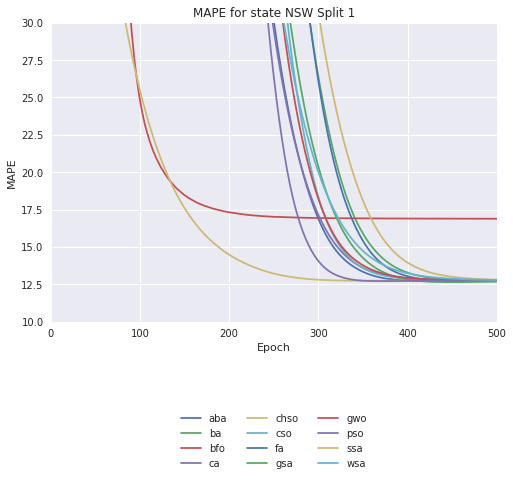

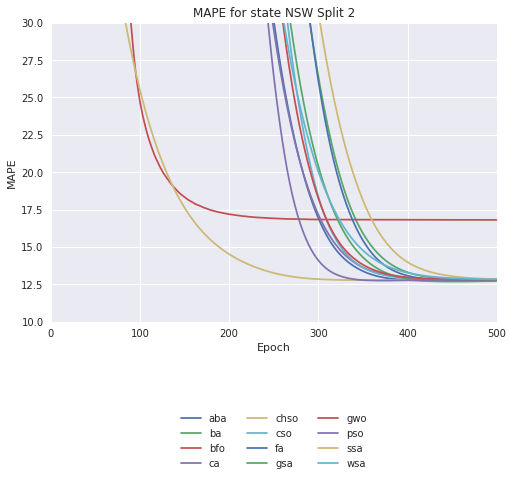

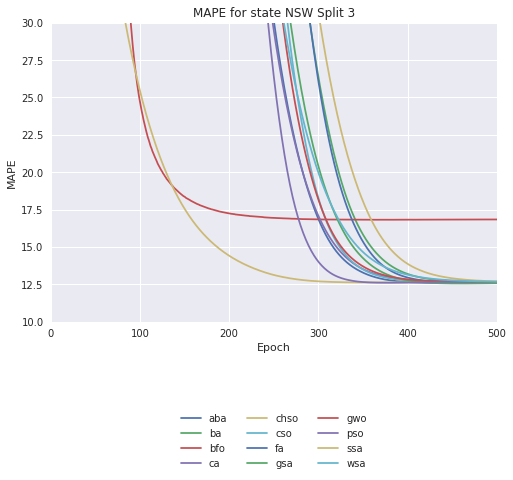

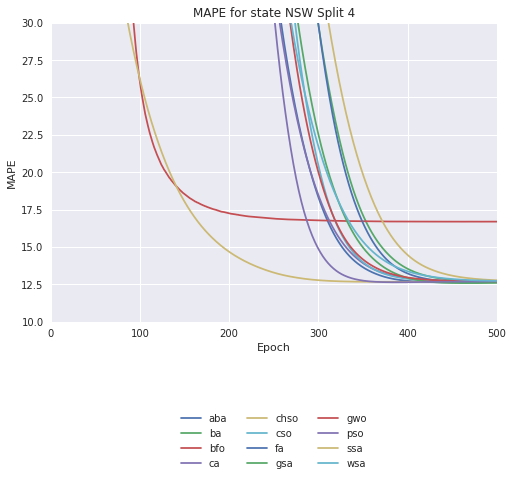

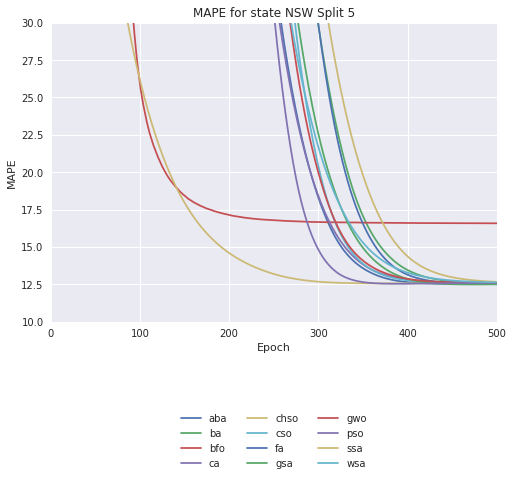

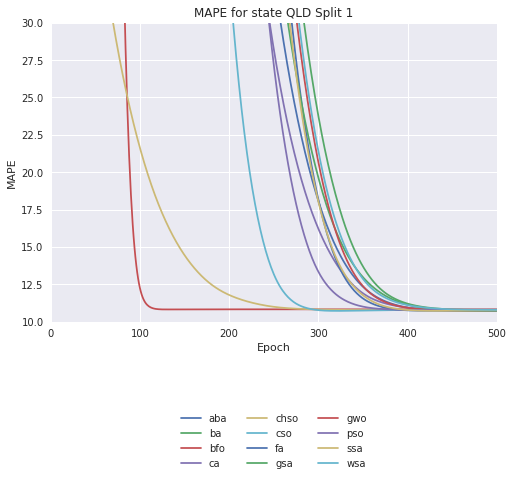

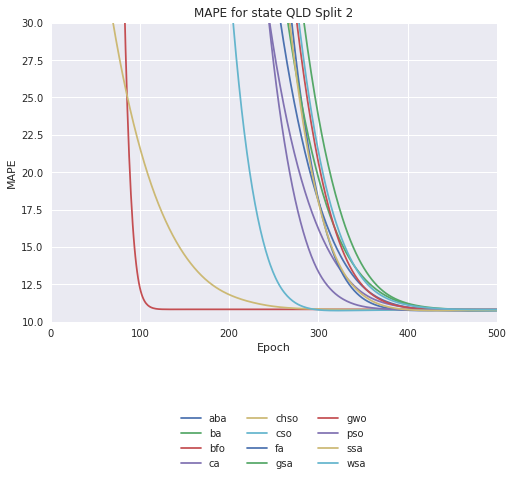

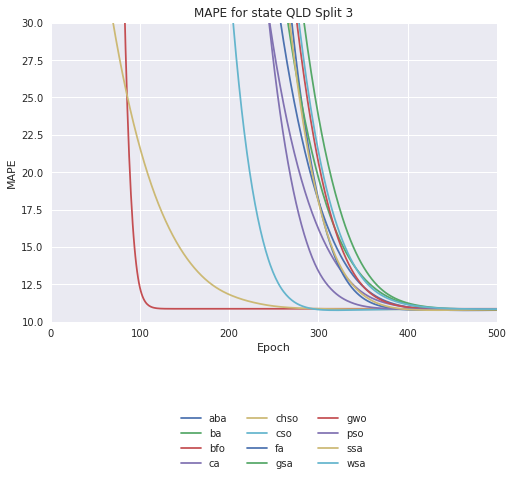

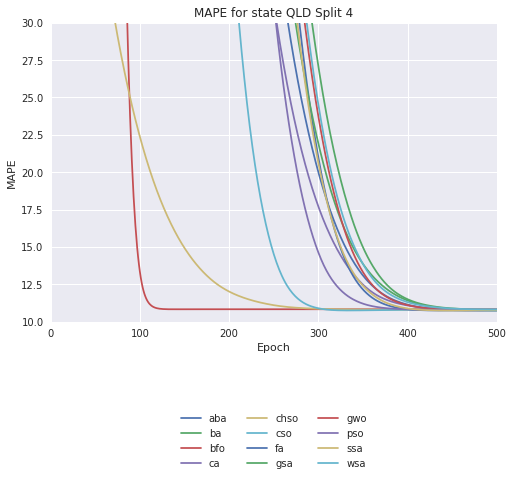

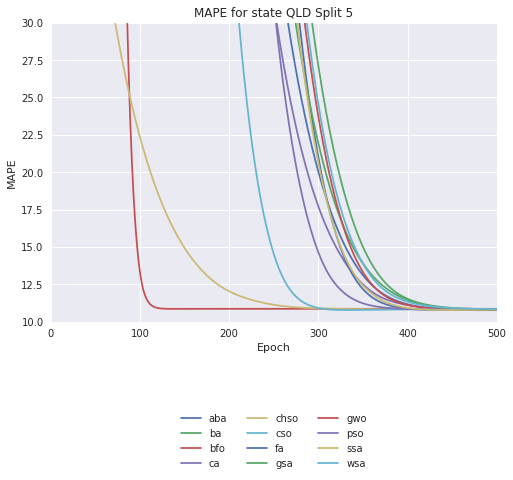

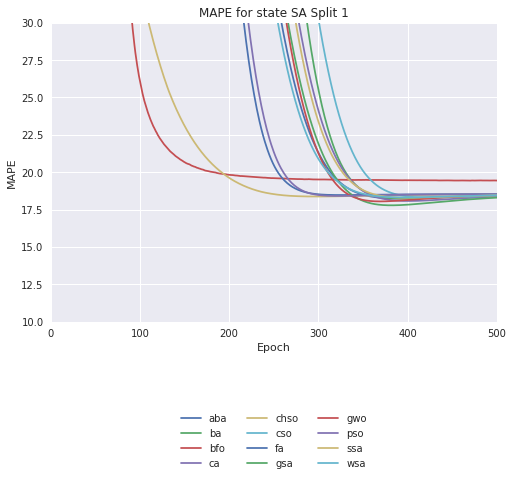

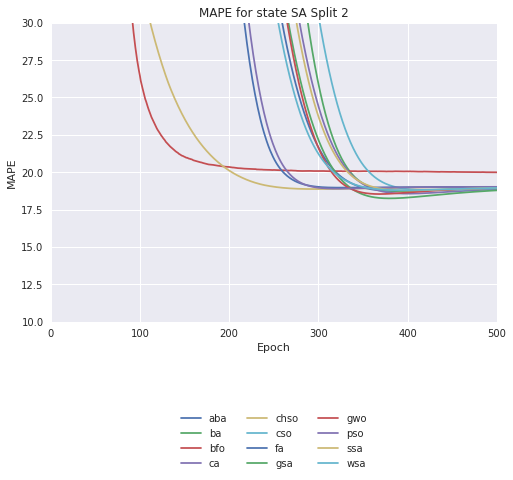

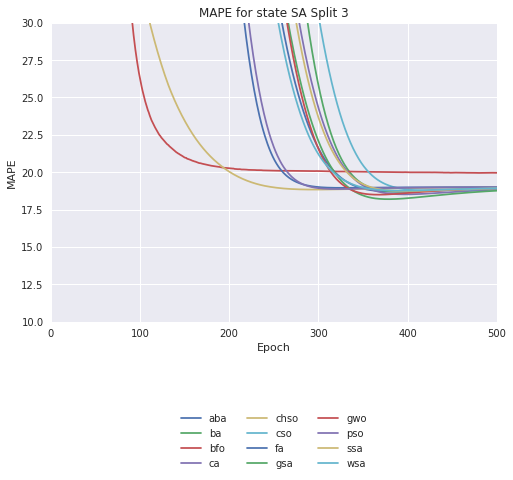

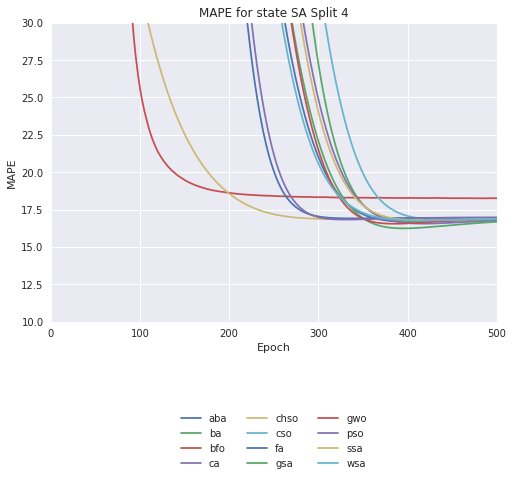

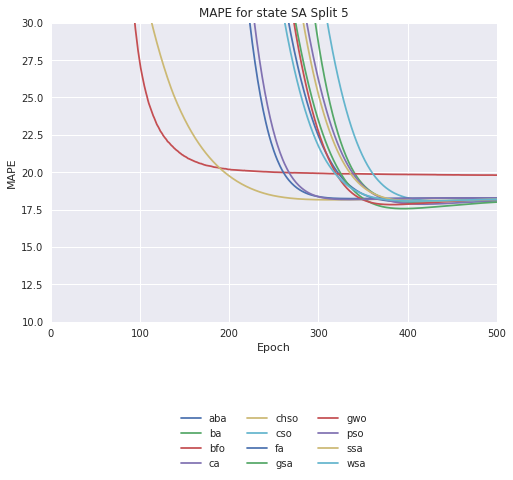

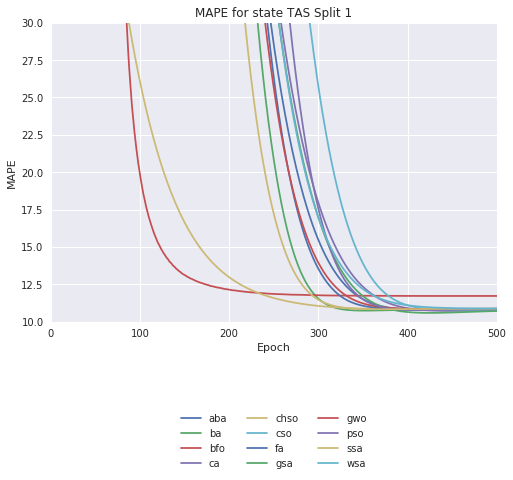

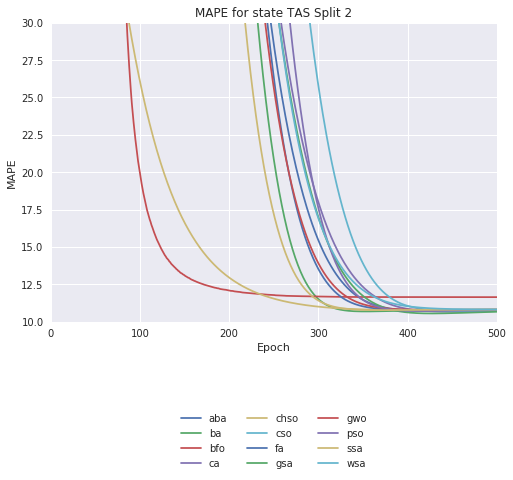

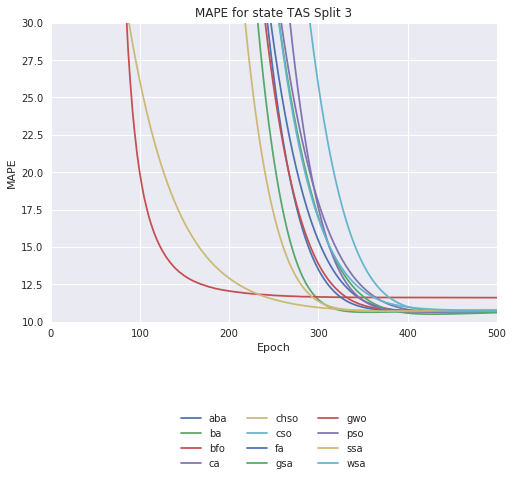

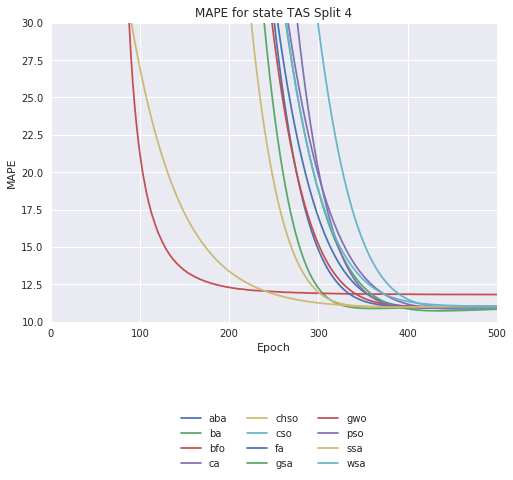

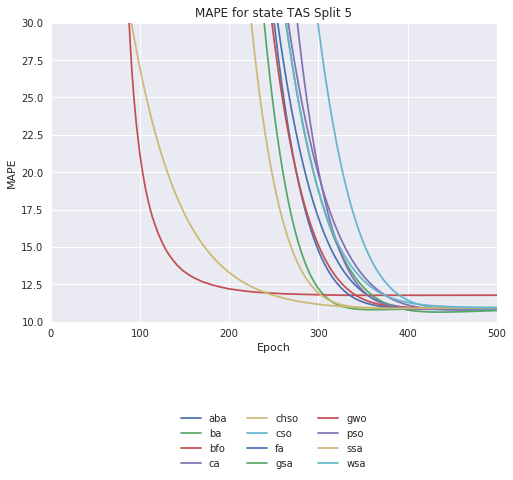

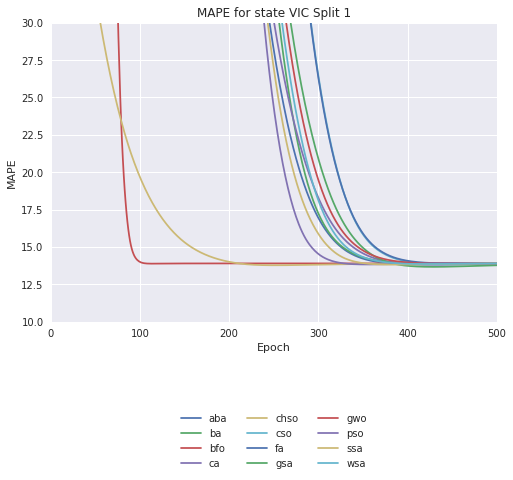

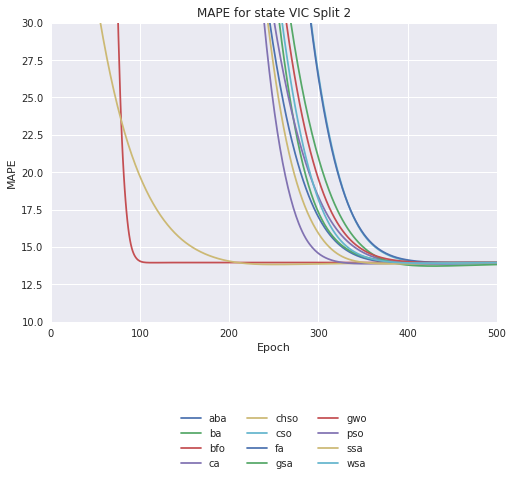

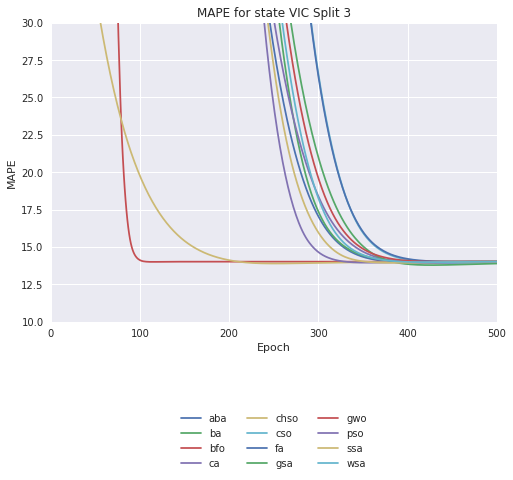

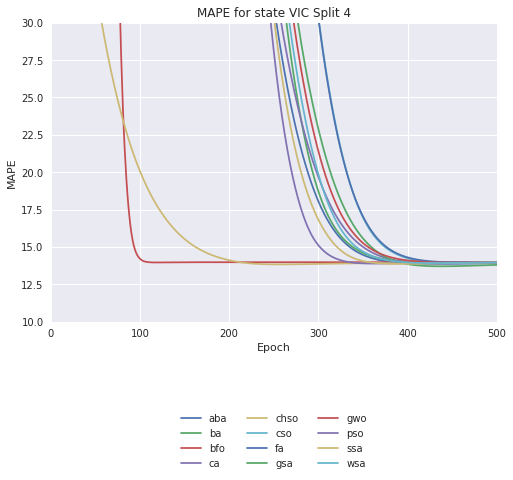

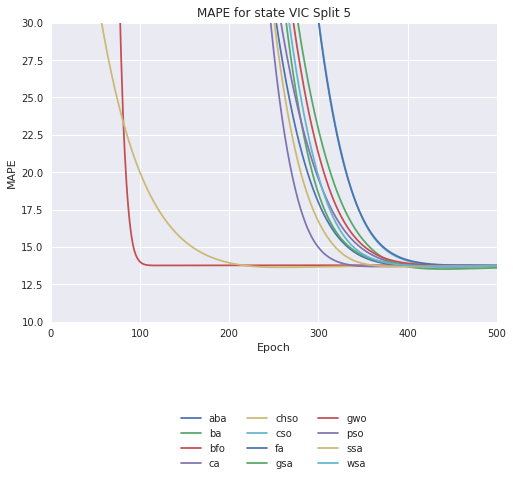

In [19]:
plot()